# Generate Embeddings with Sentence Transformers

This notebook generates vector embeddings for the markdown chunks using Sentence Transformers. These embeddings are essential for semantic search in a RAG (Retrieval-Augmented Generation) system.

We'll use the `sentence-transformers` library, which provides state-of-the-art pre-trained models specifically optimized for semantic similarity tasks.

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import pickle

# Import Sentence Transformers
from sentence_transformers import SentenceTransformer

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Define Paths

First, let's define the paths for input chunks and output embeddings.

In [2]:
# Define directories
CHUNKS_DIR = "../data/chunks"  # Directory with chunked markdown files
ALL_CHUNKS_FILE = os.path.join(CHUNKS_DIR, "all_chunks.json")  # Combined chunks file
EMBEDDINGS_DIR = "../data/embeddings"  # Directory to store embeddings

# Create embeddings directory if it doesn't exist
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

## Load Chunks

Next, let's load the chunks we created in the previous notebook.

In [3]:
def load_chunks(chunks_file):
    """
    Load chunks from a JSON file.
    
    Args:
        chunks_file (str): Path to the JSON file containing chunks
        
    Returns:
        list: List of chunk dictionaries with 'content' and 'metadata' keys
    """
    try:
        with open(chunks_file, "r", encoding="utf-8") as f:
            chunks = json.load(f)
        print(f"Loaded {len(chunks)} chunks from {chunks_file}")
        return chunks
    except FileNotFoundError:
        print(f"Error: Chunks file {chunks_file} not found. Please run the chunking notebook first.")
        return []
    except json.JSONDecodeError:
        print(f"Error: Could not parse chunks file {chunks_file}. The file may be corrupted.")
        return []

# Load all chunks
chunks = load_chunks(ALL_CHUNKS_FILE)

# Display the first few chunks to confirm they loaded correctly
if chunks:
    print(f"\nFirst chunk content (sample):")
    print("-" * 80)
    print(chunks[0]['content'][:300] + "..." if len(chunks[0]['content']) > 300 else chunks[0]['content'])
    print("-" * 80)
    print(f"Metadata: {json.dumps({k: chunks[0]['metadata'][k] for k in list(chunks[0]['metadata'].keys())[:5]}, indent=2)}...")

Loaded 389 chunks from ../data/chunks\all_chunks.json

First chunk content (sample):
--------------------------------------------------------------------------------
## MS in Applied Data Science facet-arrow-down
--------------------------------------------------------------------------------
Metadata: {
  "title": "Course Progressions \u2013 DSI",
  "original_url": "https://datascience.uchicago.edu/education/masters-programs/ms-in-applied-data-science/course-progressions",
  "category": "education",
  "date": "2025-05-04",
  "source_file": "..\\data\\markdown_clean\\education_masters-programs_ms-in-applied-data-science_course-progressions.md"
}...


## Initialize Sentence Transformer Model

Let's initialize the Sentence Transformer model. We'll use `all-MiniLM-L6-v2`, which is a good balance between performance and efficiency. For higher quality (but slower) embeddings, you could use models like `all-mpnet-base-v2`.

In [4]:
def initialize_model(model_name="all-MiniLM-L6-v2"):
    """
    Initialize a Sentence Transformer model.
    
    Args:
        model_name (str): Name of the pre-trained model to use
        
    Returns:
        SentenceTransformer: Initialized model
    """
    # Available recommended models:
    # - all-MiniLM-L6-v2: Fast and good quality (default)
    # - all-mpnet-base-v2: Higher quality but slower
    # - paraphrase-multilingual-MiniLM-L12-v2: Good for multilingual data
    
    print(f"Initializing Sentence Transformer model: {model_name}")
    model = SentenceTransformer(model_name)
    
    # Check if GPU is available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    
    return model

# Initialize the model
model = initialize_model()

# Display model information
print(f"\nModel architecture:\n{model}")
print(f"\nEmbedding dimension: {model.get_sentence_embedding_dimension()}")

Initializing Sentence Transformer model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\alen.pavlovic\Documents\GitLab\gen-ai-midterm-project\ragchat\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alen.pavlovic\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cpu

Model architecture:
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Embedding dimension: 384


## Generate Embeddings

Now let's generate embeddings for all our chunks.

In [5]:
def generate_embeddings(chunks, model, batch_size=32):
    """
    Generate embeddings for a list of chunks using a Sentence Transformer model.
    
    Args:
        chunks (list): List of chunk dictionaries
        model (SentenceTransformer): Initialized Sentence Transformer model
        batch_size (int): Batch size for embedding generation
        
    Returns:
        numpy.ndarray: Array of embeddings
    """
    if not chunks:
        return np.array([])
    
    # Extract text content from chunks
    texts = [chunk['content'] for chunk in chunks]
    
    # Generate embeddings with progress bar
    print(f"Generating embeddings for {len(texts)} chunks with batch size {batch_size}...")
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    
    print(f"Generated embeddings shape: {embeddings.shape}")
    return embeddings

# Generate embeddings
embeddings = generate_embeddings(chunks, model)

# Add embeddings to chunks
for i, embedding in enumerate(embeddings):
    chunks[i]['embedding'] = embedding.tolist()  # Convert to list for JSON serialization

Generating embeddings for 389 chunks with batch size 32...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Generated embeddings shape: (389, 384)


## Save Embeddings

Let's save the embeddings for future use.

In [6]:
def save_embeddings(chunks_with_embeddings, embeddings_dir):
    """
    Save chunks with embeddings to files.
    
    Args:
        chunks_with_embeddings (list): List of chunks with embeddings
        embeddings_dir (str): Directory to save embeddings
    """
    # Save chunks with embeddings as JSON
    json_path = os.path.join(embeddings_dir, "chunks_with_embeddings.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(chunks_with_embeddings, f)
    
    # Also save as pickle for more efficient loading with numpy arrays
    pickle_path = os.path.join(embeddings_dir, "chunks_with_embeddings.pkl")
    with open(pickle_path, "wb") as f:
        pickle.dump(chunks_with_embeddings, f)
    
    # Extract embeddings as numpy array for efficient operations
    embeddings_array = np.array([chunk['embedding'] for chunk in chunks_with_embeddings])
    np_path = os.path.join(embeddings_dir, "embeddings.npy")
    np.save(np_path, embeddings_array)
    
    # Save metadata separately for easy access
    metadata = [{
        'chunk_id': i,
        'content': chunk['content'],
        **chunk['metadata']
    } for i, chunk in enumerate(chunks_with_embeddings)]
    
    metadata_path = os.path.join(embeddings_dir, "metadata.json")
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f)
    
    print(f"Saved embeddings to:")
    print(f"- {json_path} (JSON format with embeddings)")
    print(f"- {pickle_path} (Pickle format with embeddings)")
    print(f"- {np_path} (NumPy array of embeddings only)")
    print(f"- {metadata_path} (JSON with metadata only)")

# Save the embeddings
save_embeddings(chunks, EMBEDDINGS_DIR)

Saved embeddings to:
- ../data/embeddings\chunks_with_embeddings.json (JSON format with embeddings)
- ../data/embeddings\chunks_with_embeddings.pkl (Pickle format with embeddings)
- ../data/embeddings\embeddings.npy (NumPy array of embeddings only)
- ../data/embeddings\metadata.json (JSON with metadata only)


## Analyze Embeddings

Let's analyze and visualize the embeddings to ensure they capture the semantic relationships appropriately.

Embeddings shape: (389, 384)
Embedding dimension: 384
Mean embedding: [-0.01662645 -0.0171878   0.00842507  0.00291202  0.00517277]... (showing first 5 dimensions)
Standard deviation: [0.04151045 0.04298594 0.04669923 0.03743123 0.03908362]... (showing first 5 dimensions)


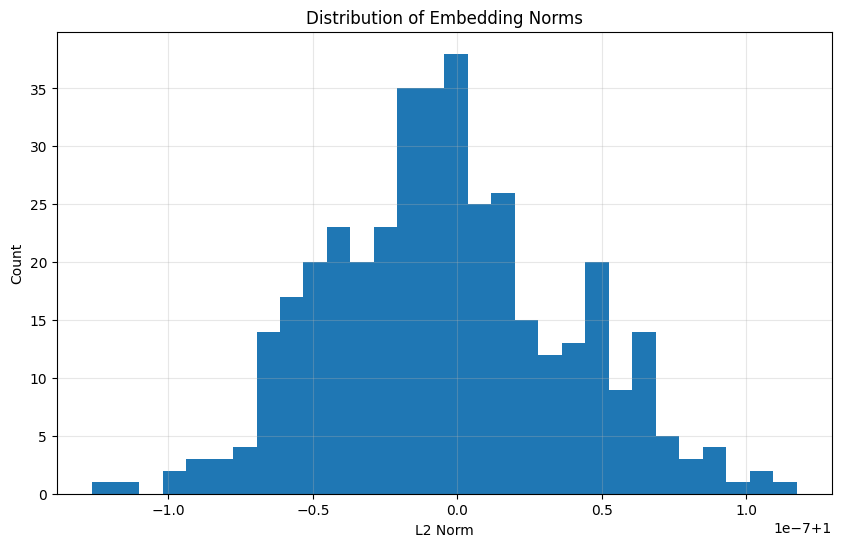

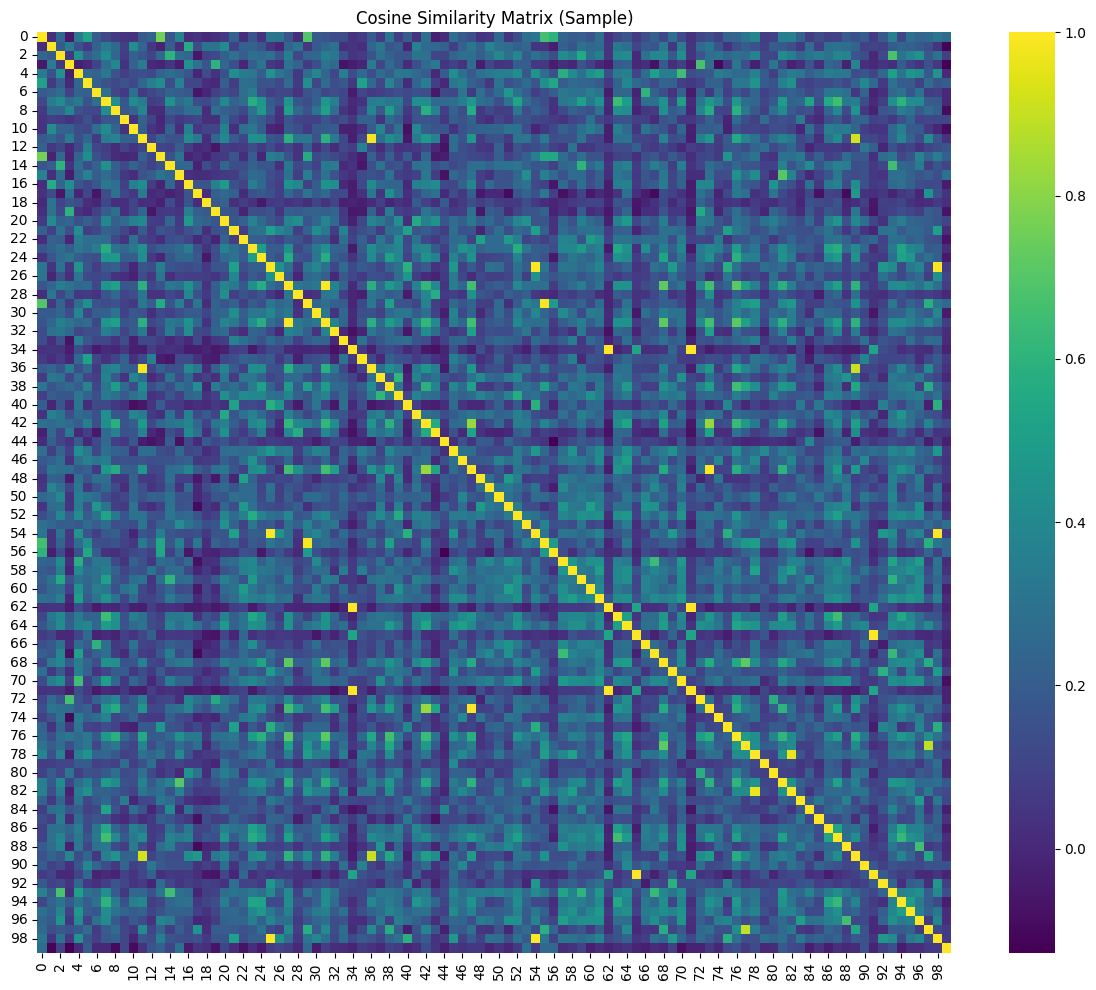

In [7]:
def analyze_embeddings(embeddings, chunks):
    """
    Analyze and visualize embeddings.
    
    Args:
        embeddings (numpy.ndarray): Array of embeddings
        chunks (list): List of chunks with metadata
    """
    # Basic statistics
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    
    # Compute mean and standard deviation
    mean_embedding = np.mean(embeddings, axis=0)
    std_embedding = np.std(embeddings, axis=0)
    
    print(f"Mean embedding: {mean_embedding[:5]}... (showing first 5 dimensions)")
    print(f"Standard deviation: {std_embedding[:5]}... (showing first 5 dimensions)")
    
    # Plot histogram of embedding norms
    embedding_norms = np.linalg.norm(embeddings, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.hist(embedding_norms, bins=30)
    plt.title("Distribution of Embedding Norms")
    plt.xlabel("L2 Norm")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Compute a similarity matrix for a sample of embeddings
    sample_size = min(100, len(embeddings))  # Use at most 100 embeddings to avoid excessive computation
    sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)
    
    sample_embeddings = embeddings[sample_indices]
    sample_chunks = [chunks[i] for i in sample_indices]
    
    # Compute cosine similarity matrix
    similarity_matrix = np.zeros((sample_size, sample_size))
    
    for i in range(sample_size):
        for j in range(sample_size):
            similarity_matrix[i, j] = np.dot(sample_embeddings[i], sample_embeddings[j]) / \
                                       (np.linalg.norm(sample_embeddings[i]) * np.linalg.norm(sample_embeddings[j]))
    
    # Plot similarity matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, cmap="viridis")
    plt.title("Cosine Similarity Matrix (Sample)")
    plt.tight_layout()
    plt.show()
    
    # Calculate average similarity by category (if available)
    categories = [chunk['metadata'].get('category', 'unknown') for chunk in chunks]
    unique_categories = list(set(categories))
    
    if len(unique_categories) > 1:
        category_df = pd.DataFrame({
            'category': categories,
            'embedding_norm': embedding_norms
        })
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='category', y='embedding_norm', data=category_df)
        plt.title("Embedding Norms by Category")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Load the embeddings as numpy array for analysis
embeddings_array = np.array([chunk['embedding'] for chunk in chunks])

# Analyze the embeddings
analyze_embeddings(embeddings_array, chunks)

## Test Semantic Search

Let's do a simple test to see if our embeddings can retrieve semantically relevant content.

In [8]:
def perform_semantic_search(query, model, chunks, top_k=5):
    """
    Perform semantic search using embeddings.
    
    Args:
        query (str): Query to search for
        model (SentenceTransformer): Model for embedding generation
        chunks (list): List of chunks with embeddings
        top_k (int): Number of top results to return
        
    Returns:
        list: Top-k most relevant chunks
    """
    # Generate query embedding
    query_embedding = model.encode(query, convert_to_numpy=True)
    
    # Compute similarities
    similarities = []
    for i, chunk in enumerate(chunks):
        chunk_embedding = np.array(chunk['embedding'])
        similarity = np.dot(query_embedding, chunk_embedding) / \
                    (np.linalg.norm(query_embedding) * np.linalg.norm(chunk_embedding))
        similarities.append((i, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Return top-k results
    top_indices = [idx for idx, _ in similarities[:top_k]]
    top_chunks = [chunks[idx] for idx in top_indices]
    top_scores = [score for _, score in similarities[:top_k]]
    
    return top_chunks, top_scores

# Test queries
test_queries = [
    "What courses are required for the Masters in Data Science?",
    "Who teaches machine learning in the program?",
    "How long does it take to complete the degree?",
    "What are the capstone project requirements?"
]

# Perform semantic search for each query
for query in test_queries:
    print(f"\nQuery: {query}")
    print("-" * 80)
    
    top_chunks, scores = perform_semantic_search(query, model, chunks)
    
    for i, (chunk, score) in enumerate(zip(top_chunks, scores)):
        print(f"Result {i+1} (Score: {score:.4f})")
        print(f"Source: {chunk['metadata'].get('filename', 'Unknown')}")
        print(f"Content:\n{chunk['content'][:200]}..." if len(chunk['content']) > 200 else f"Content:\n{chunk['content']}")
        print("-" * 80)


Query: What courses are required for the Masters in Data Science?
--------------------------------------------------------------------------------
Result 1 (Score: 0.6987)
Source: education_masters-programs_ms-in-applied-data-science_online-program.md
Content:
Foundational noncredit courses are designed and taught by Master’s in Applied Data Science [faculty and instructors](https://datascience.uchicago.edu/education/masters-programs/ms-in-applied-data-scie...
--------------------------------------------------------------------------------
Result 2 (Score: 0.6986)
Source: education_masters-programs_ms-in-applied-data-science_online-program.md
Content:
### Core Courses (6)

You will complete 6 core courses toward your [Master’s in Applied Data Science](https://datascience.uchicago.edu/education/masters-programs/ms-in-applied-data-science/instructors...
--------------------------------------------------------------------------------
Result 3 (Score: 0.6472)
Source: education_masters-pro